# Introduction

In this notebook, we will create a dataset using four well-separated 2D Gaussians, each representing a different class, and use a neural network to classify these Gaussians. Let's begin with necessary imports.

In [34]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split, DataLoader
from torch.utils.data.dataset import Subset
from torch.optim.sgd import SGD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

# Creating the Dataset

Now let's build our dataset. We will have a total of $4000$ samples, with $1000$ samples per class. The distributions for each class will be centered at $(\pm 10, \pm 10)$ and will all have a variance of $(5, 5)$. we will use $10\%$ of our data for testing and the rest for training. We will also be using a batch size of $64$.

In [35]:
class_centers: list[list[int]] = [
    [10, 10],
    [10, -10],
    [-10, 10],
    [-10, -10]
]
variance: list[list[int]] = [
    [5, 0],
    [0, 5]
]
samples_per_class: int = 1000
X: np.ndarray = np.concatenate([
    np.random.multivariate_normal(mean=center, cov=variance, size=samples_per_class)
    for center in class_centers
])
Y: np.ndarray = np.concatenate([
    np.array([i] * samples_per_class) for i in range(len(class_centers))
])

Let's first take a look at our dataset.

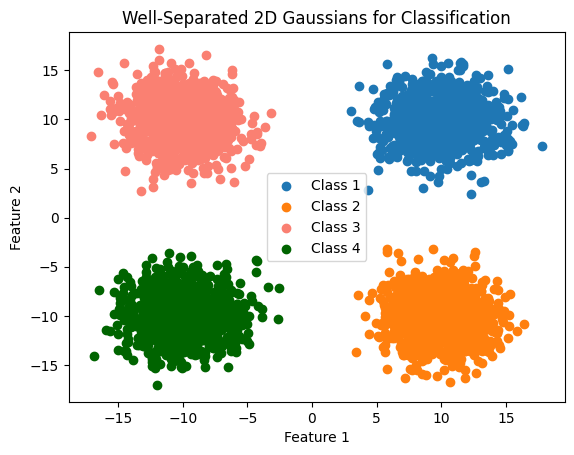

In [36]:
clss: int
colors: list[str] = ['tab:blue', 'tab:orange', 'salmon', 'darkgreen']
for clss in range(len(class_centers)):
    start: int = clss * samples_per_class
    end: int = (clss + 1) * samples_per_class
    plt.scatter(X[start:end, 0], X[start:end, 1], label=f"Class {clss + 1}", c=colors[clss])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Well-Separated 2D Gaussians for Classification")
plt.legend()
plt.show()

Now let's split it and put it into `Dataloader`s.

In [37]:
X_tensor: torch.Tensor = torch.from_numpy(X).to(torch.float32)
Y_tensor: torch.Tensor = torch.from_numpy(Y).to(torch.int64)

In [38]:
dataset: TensorDataset = TensorDataset(X_tensor, Y_tensor)
split_size: int = int(len(dataset) * 0.1)
train_set: Subset; test_set: Subset
train_set, test_set = random_split(dataset, [len(dataset) - split_size, split_size])

In [39]:
train_dataloader: DataLoader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader: DataLoader = DataLoader(test_set, batch_size=64, shuffle=False)

# Building the Classifier

Now let's build our classifier. Our classifier will take in a two-dimensional input, have one hidden layer with $8$ neurons, and output a softmaxed prediction across four classes. It will have a learning rate of $0.01$ and only needs to train for $10$ epochs using the ``torch.optim.SGD`` optimizer.

In [40]:
class NN_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1: nn.Linear = nn.Linear(2, 8)
        self.linear2: nn.Linear = nn.Linear(8, 4)
        self.relu: nn.ReLU = nn.ReLU()
        self.log_softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [41]:
lr: float = 0.01
epochs: int = 10

model: NN_Classifier = NN_Classifier().cuda()
loss: nn.NLLLoss = nn.NLLLoss()
optimizer: SGD = SGD(model.parameters(), lr=lr)

Let's take a look at our model.

In [42]:
model

NN_Classifier(
  (linear1): Linear(in_features=2, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
  (log_softmax): LogSoftmax(dim=1)
)

# Training the Model

Now let's train the model. Every epoch, we will record and print out the train loss, test loss, and time elapsed.

In [43]:
metrics: list[str] = ['Train Loss', 'Test Loss']
history: pd.DataFrame = pd.DataFrame(columns=metrics)

for epoch in range(epochs):
    train_loss: float = 0.0
    test_loss: float = 0.0
    start_time: float = time()
    i: int; x: torch.Tensor; y: torch.Tensor
    print(f'Epoch {epoch + 1}')
    print('Training...')
    for i, (x, y) in enumerate(tqdm(train_dataloader)):
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        y_pred: torch.Tensor = model(x)
        fit: torch.Tensor = loss(y_pred, y)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
    train_loss /= len(train_dataloader)
    print(f'Train Loss: {train_loss}')
    print('Testing...')
    for i, (x, y) in enumerate(tqdm(test_dataloader)):
        with torch.no_grad():
            x = x.cuda()
            y = y.cuda()
            y_pred = model(x)
            fit = loss(y_pred, y)
            test_loss += fit.item()
    test_loss /= len(test_dataloader)
    history.loc[len(history)] = [train_loss, test_loss]
    time_elapsed: float = time() - start_time
    print(f'Test Loss: {test_loss}')
    print(f'Time Elapsed: {time_elapsed:.2f}s')

Epoch 1
Training...


100%|██████████| 57/57 [00:00<00:00, 296.77it/s]


Train Loss: 0.4393400577991678
Testing...


100%|██████████| 7/7 [00:00<00:00, 629.25it/s]


Test Loss: 0.049899796822241375
Time Elapsed: 0.21s
Epoch 2
Training...


100%|██████████| 57/57 [00:00<00:00, 346.18it/s]


Train Loss: 0.03258012258039232
Testing...


100%|██████████| 7/7 [00:00<00:00, 731.08it/s]


Test Loss: 0.02262998771454607
Time Elapsed: 0.18s
Epoch 3
Training...


100%|██████████| 57/57 [00:00<00:00, 436.86it/s]


Train Loss: 0.018017482698747988
Testing...


100%|██████████| 7/7 [00:00<00:00, 822.21it/s]


Test Loss: 0.014683810328798634
Time Elapsed: 0.14s
Epoch 4
Training...


100%|██████████| 57/57 [00:00<00:00, 454.31it/s]


Train Loss: 0.01258434531720061
Testing...


100%|██████████| 7/7 [00:00<00:00, 924.58it/s]


Test Loss: 0.010933510693056243
Time Elapsed: 0.14s
Epoch 5
Training...


100%|██████████| 57/57 [00:00<00:00, 441.03it/s]


Train Loss: 0.009758915980918366
Testing...


100%|██████████| 7/7 [00:00<00:00, 726.79it/s]


Test Loss: 0.008745610847004823
Time Elapsed: 0.15s
Epoch 6
Training...


100%|██████████| 57/57 [00:00<00:00, 414.59it/s]


Train Loss: 0.007950260753236842
Testing...


100%|██████████| 7/7 [00:00<00:00, 874.99it/s]


Test Loss: 0.00731956832376974
Time Elapsed: 0.15s
Epoch 7
Training...


100%|██████████| 57/57 [00:00<00:00, 435.39it/s]


Train Loss: 0.00673801835070838
Testing...


100%|██████████| 7/7 [00:00<00:00, 931.12it/s]


Test Loss: 0.0063113558239170486
Time Elapsed: 0.14s
Epoch 8
Training...


100%|██████████| 57/57 [00:00<00:00, 424.78it/s]


Train Loss: 0.005866105022856541
Testing...


100%|██████████| 7/7 [00:00<00:00, 821.81it/s]


Test Loss: 0.005561005989355701
Time Elapsed: 0.15s
Epoch 9
Training...


100%|██████████| 57/57 [00:00<00:00, 355.44it/s]


Train Loss: 0.0052403769570223075
Testing...


100%|██████████| 7/7 [00:00<00:00, 774.29it/s]


Test Loss: 0.004973874859777945
Time Elapsed: 0.18s
Epoch 10
Training...


100%|██████████| 57/57 [00:00<00:00, 394.09it/s]


Train Loss: 0.004726018478865163
Testing...


100%|██████████| 7/7 [00:00<00:00, 966.68it/s]

Test Loss: 0.004505167748512966
Time Elapsed: 0.16s


# Analyzing the Model

Let's print the train and test loss curves.

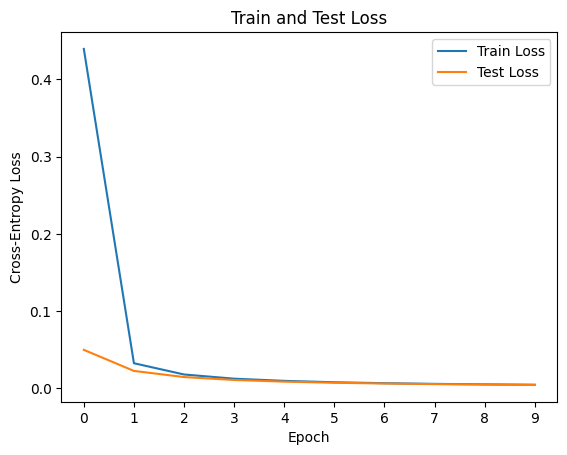

In [49]:
plt.plot(history.index, history['Train Loss'], label="Train Loss")
plt.plot(history.index, history['Test Loss'], label="Test Loss")
plt.title("Train and Test Loss")
plt.xticks(range(epochs))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

The train loss drops extremely quickly after the first epoch. It's evident the model has almost completely converged during this first epoch because the test loss is immediately much lower than the train loss (and much closer to the final train/test loss). It may seem odd that the test loss is always lower than the train loss, but this occurs since all of the testing happens after all of the training at each epoch. The dataset is extremely well-separated, so improvement in the test and train sets is very correlated (and the model is too simple for overfitting to counteract this). Therefore, after going through the full epoch of training on the train set, the test performance will be better than the average performance over the train set from that epoch.

Now let's take a look at our final train and test accuracies.

In [46]:
x: torch.Tensor; y: torch.Tensor
correct_predictions: int = 0
total_samples = len(train_dataloader.dataset)
for i, (x, y) in enumerate(tqdm(train_dataloader)):
        with torch.no_grad():
            x = x.cuda()
            y = y.cuda()
            out: torch.Tensor = model(x)
            y_pred: torch.Tensor
            _, y_pred = torch.max(out, dim=1)
            correct_predictions += (y_pred == y).sum().item()
print(f"Final Train Accuracy: {correct_predictions * 100 / total_samples}%")
correct_predictions: int = 0
total_samples = len(test_dataloader.dataset)
for i, (x, y) in enumerate(tqdm(test_dataloader)):
        with torch.no_grad():
            x = x.cuda()
            y = y.cuda()
            out: torch.Tensor = model(x)
            y_pred: torch.Tensor
            _, y_pred = torch.max(out, dim=1)
            correct_predictions += (y_pred == y).sum().item()
print(f"Final Test Accuracy: {correct_predictions * 100 / total_samples}%")

100%|██████████| 57/57 [00:00<00:00, 490.84it/s]


Final Train Accuracy: 100.0%


100%|██████████| 7/7 [00:00<00:00, 493.25it/s]

Final Test Accuracy: 100.0%


We've achieved $100\%$ accuracy on both the train and test set, which makes sense, as the dataset was exceptionally simple.